In [1]:
import glob
import tqdm
from tqdm import tqdm_notebook
from nltk import word_tokenize
import nltk
import spacy
import string
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import collections
#from __future__ import print_function
import argparse
import os
import json
import time
import logging
import re
from collections import Counter
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)
punctuations = list(string.punctuation)
stopwords = nltk.corpus.stopwords.words("english")


In [2]:
def readFileNew_withTime(filename):
    '''
    This function is used to find out how much time a user would need to respond to a question
    input: transcript file name
    output: a list with timestamps within one transcript
    e.g. ['2019-03-31 12:32', '2019-03-31 12:32', ...]
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+1
                temp_list.append(line[:indSentenceSt])
            else:
                indSentenceSt = line.find(']')+1
                if 'wording' in line:
                    temp_text = line[line.find(':wording')+8 : line.find(':qid')]
                    temp_list.append(line[:indSentenceSt])
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(line[:indSentenceSt])
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list
def readFileNew(filename):
    '''
    input: transcript file name
    output: a list contains all the text
    e.g. ['Juji: Can you introduce yourself?', 'User: I love swimming', 'Juji: Thank you! Goodbye.']
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+2
                temp_list.append(line[indSentenceSt:])
            else:
                if 'wording' in line:
                    subline = line[line.find(':wording')+8 : ]
                    temp_text = subline[:subline.index(',')]
                    if '<' in temp_text and '>' in temp_text and '*' in temp_text:
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        temp_text = temp_text.replace('*','')
                    temp_list.append(botName + ': ' + temp_text)
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(personName+': A')
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list,count,botName
#remove transcrips that do not chat
def filterNonChattingTranscripts(transcripts_name):
    '''
    This function filters out empty transctipts
    input: a list of transcript files names
    output: 
        transcripts_afterFilter: a list with 'readFileNew' funtion's return value
        transcripts_withTime_afterFilter: a list with 'readFileNew_withTime' function's return value
        resbotName: bot's name
    '''
    all_transcripts = []
    filtered_transcripts = []
    
    transcripts_afterFilter = []
    count_choiceQuestions = []
    transcripts_withTime_afterFilter = []
    for i in range(len(transcripts_name)):
        t,c,botName = readFileNew(transcripts_name[i])
        t_time = readFileNew_withTime(transcripts_name[i])
        if botName != '':
            resbotName = botName
        all_transcripts.append(t)
        flag = True
        for j in range(len(t)):
            if not t[j].startswith(resbotName):
                flag = False
                break
                
        if flag:
            filtered_transcripts.append(t)
        else:
            transcripts_afterFilter.append(t)
            count_choiceQuestions.append(c)
            
            transcripts_withTime_afterFilter.append(t_time)
    return transcripts_afterFilter, transcripts_withTime_afterFilter,resbotName

#read from edn file to get question list
def getQuestions(filename):
    '''
    input: edn file name
    output: question list with punctuations removed
    '''
    QList = []
    with open(filename) as f:
        lines = f.readlines()
        flag = 0
        for line in lines:
            if flag:
                lBracket, rBracket = line.find('['), line.find(']')
                question = line[lBracket+2:rBracket-1]
                QList.append(question)
                flag = 0
                continue
            if ':wording' in line and ';;' not in line:
                flag = 1
    for i in range(len(QList)):
        if 'Are you working for' in QList[i]:
            QList[i] = 'Are you working for?'
    
    for j in range(len(QList)):
            QList[j]=QList[j].rstrip('\r')
            QList[j]=QList[j].replace("\r", " ")
            QList[j]=QList[j].strip()
            QList[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(QList[j]) if k not in punctuations])
        
    return QList

#get question blocks
def groupQuestions(sentences,sentences_time,questions,botName):
    '''
    input: 
        sentences: the sentences list from "readFileNew" function's return value
        sentences_time: the timestamp list from "readFileNew_withTime" function's return value
        questions: question list
        botName
        
    output: 
        questionDict: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        
        questionDict_Time: a dict with key = question in question list, value = timestamp of the conversation block
        e.g {'q1': ['timestamp1', 'timestampe2'], ...}
    '''
    #sentences = readFile(filename)
    temp_list=[]
    last= 0
    lastq = 'starting'
    #nlp = spacy.load('en_pytt_bertbaseuncased_lg')
    Th = 0.7
    questionDict = collections.OrderedDict()
    questionDict_time = collections.OrderedDict()
    for i in range(len(sentences)):
        match = 0
        if sentences[i].startswith(botName+':'):#[:5] == 'Juji:':
            sen_rmPunct = ' '.join([i.strip("".join(punctuations)) for i in word_tokenize(sentences[i].strip()) if i not in punctuations])
            #print(sen_rmPunct)
            for q in questions:
                if q in sen_rmPunct:
                    match = 1   
                    
                    if lastq in questionDict:
                        questionDict[lastq] += sentences[last:i]
                        questionDict_time[lastq] += sentences_time[last:i]
                    else:
                        questionDict[lastq] = sentences[last:i]
                        questionDict_time[lastq] = sentences_time[last:i]
                    lastq = q
                    #temp_list.append(sentences[last:i])
                    if "Are you working for" in q:
                        lastq = "Are you working for"
                    last = i

    #temp_list.append(sentences[last:])
    if lastq in questionDict:
        questionDict[lastq] += sentences[last:]
        questionDict_time[lastq] += sentences_time[last:]
    else:
        questionDict[lastq] = sentences[last:]
        questionDict_time[lastq] = sentences_time[last:]
    #print(questionDict)
    return questionDict, questionDict_time#list(questionDict.values())
def groupQuestions_csv(filename):
    '''
    input: 
        csv file name
        
    output: 
        qBlocks: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        qList: question list
        
    '''
    df = pd.read_csv(filename,encoding='iso8859-1')
    botName = 'Juji'
    qBlocks = []
    qList = df.columns.tolist()[5:]
    finalQuestion = 'Any final thoughts?'
    qList_normal = qList[:qList.index(finalQuestion)+1]
    qList_addtional = qList[qList.index(finalQuestion)+1:]
    
    for i in range(len(df)):
        block = collections.OrderedDict()
        line = df.iloc[i]
        if pd.isnull(line[qList_normal[0]]):
            continue
        for q in qList_normal:
            if not pd.isnull(line[q]):
                block[q] = [botName+':'+q, line['Name']+':'+str(line[q])]
            #else:
            #    block[q] = [botName+':'+q]
            #    break
        qBlocks.append(block)
        
    '''    
    #remove punctuation in question list
    for j in range(len(qList_normal)):
            qList_normal[j]=qList_normal[j].rstrip('\r')
            qList_normal[j]=qList_normal[j].replace("\r", " ")
            qList_normal[j]=qList_normal[j].strip()
            qList_normal[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(qList_normal[j]) if k not in punctuations])
    for j in range(len(qList_addtional)):
            qList_addtional[j]=qList_addtional[j].rstrip('\r')
            qList_addtional[j]=qList_addtional[j].replace("\r", " ")
            qList_addtional[j]=qList_addtional[j].strip()
            qList_addtional[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(qList_addtional[j]) if k not in punctuations])
    '''
    return qBlocks,qList_normal



In [14]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
def getSentenceInformativeness_length(sentence,wordFreq):
    '''
    input: sentence: A single sentence of user
           dic: a dictionary containing word frequency calculated from Wikipedia corpus
    output: an integer representing the input sentence's informativeness
            sentence word count
    '''
    #sen = sentence[sentence.index(':')+1:].strip()
    sen = ' '.join([k.strip("".join(punctuations)).lower() for k in word_tokenize(sentence) if k not in punctuations])
    freqLst = []
    stopwordsFreq = sum([wordFreq[w] for w in stopwords if w in wordFreq])/len([w for w in stopwords if w in wordFreq])
    for word in sen.split():
        if word in wordFreq:
            freqLst.append(wordFreq[word])
        elif len(word)==1 or is_number(word):
            freqLst.append(stopwordsFreq)
    return sum([np.log2(1/freq) for freq in freqLst]), len(sen.split())

def getResponseInformativeness_length(trans_block,wordFreq,botName,qList):
    '''
    input: trans_block: a list of dicts with key = question in question list, value = conversation block under the key question
        e.g [{'q1': ['Juji: q1', 'User1: answer to q1'], ...}, {'q1': ['Juji: q1', 'User2: answer to q1'], ...} ... ]
           dic: a dictionary containing word frequency calculated from Wikipedia corpus
           botName
    output: response_informativeness: a dict with key = question, value = user's avg response informativeness to that question(key)
            response_length: a dict with key = question, value = user's avg response word count to that question(key)
    '''
    response_informativeness = []
    response_length = []
    sentenceCount = 0
    for block in trans_block:
        informativeness = {}
        length = {}
        for question in block:
            response = ''
            for line in block[question]:
                if not line.startswith(botName):
                    response += line[line.index(':')+1:]
            informativeness[question],length[question] = getSentenceInformativeness_length(response,wordFreq)
        response_informativeness.append(informativeness)
        response_length.append(length)
        
    #get response's avg infomativeness and length by question
    qResInfo = collections.defaultdict(list)
    qResLen = collections.defaultdict(list)
    for item in response_informativeness:
        for q in item:
            qResInfo[q].append(item[q])
    for item in response_length:
        for q in item:
            qResLen[q].append(item[q])
    resInfo = {}
    resLen = {}
    for q in qResInfo:
        resInfo[q] = np.mean(qResInfo[q])
    for q in qResInfo:
        resLen[q] = np.mean(qResLen[q])
    return resInfo,resLen
        

In [15]:
#read word frequency from file, return a dict
def getWordFreq(filename):
    wordFreq = {}
    
    with open(filename) as fp:
        lines = fp.readlines()
        for line in lines:
            info = line.split()
            wordFreq[info[0]] = int(info[1])
    total = sum(wordFreq.values())
    for item in wordFreq:
        wordFreq[item] = wordFreq[item] / total
    return wordFreq

In [16]:
import matplotlib.pyplot as plt
def visRes(qList, dic, ylabel):
    plt.figure()
    rate = [dic[q] for q in qList if q in dic]
    question = [q for q in qList if q in dic]
    plt.plot(question,rate)
    plt.xticks(rotation=90)
    plt.ylabel(ylabel)

In [17]:
def main(readCsv=False,csvFileName=None, transcriptFilesPath=None,qListPath=None):
    wordFreq = getWordFreq('resource/enwiki-20190320-words-frequency.txt')
    if readCsv:
        transcripts_blocks,q = groupQuestions_csv(csvFileName)
        botName = 'Juji'
        
    else:
        transcripts_blocks = []
        transcripts_name = glob.glob(transcriptFilesPath)
        transcripts_afterFilter, transcripts_withTime_afterFilter,botName = filterNonChattingTranscripts(transcripts_name)
        q = getQuestions(qListPath)
        
        
        for i in tqdm.tqdm_notebook(range(len(transcripts_afterFilter))):
            trans_block, trans_block_time = groupQuestions(transcripts_afterFilter[i],transcripts_withTime_afterFilter[i],q,botName)
            transcripts_blocks.append(trans_block)

    qResInfo,qResLen = getResponseInformativeness_length(transcripts_blocks,wordFreq,botName,q)
    visRes(q, qResInfo, 'Informativeness')
    visRes(q, qResLen, 'Length')
    return qResInfo,qResLen

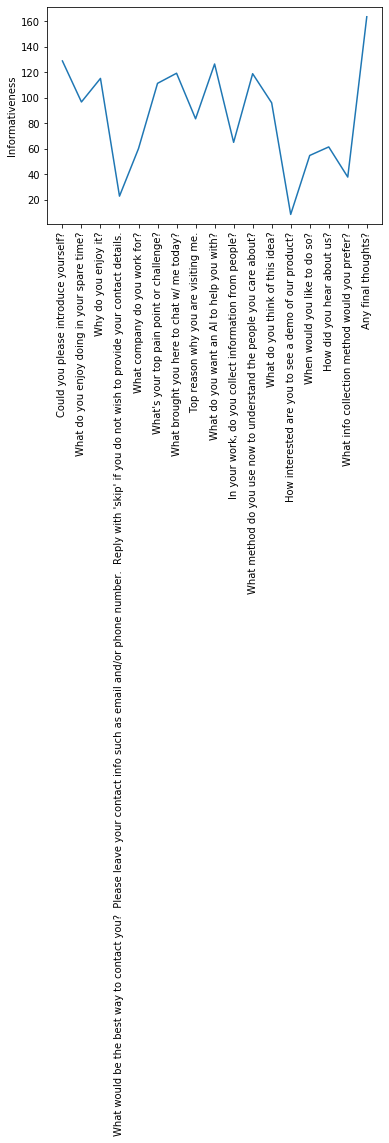

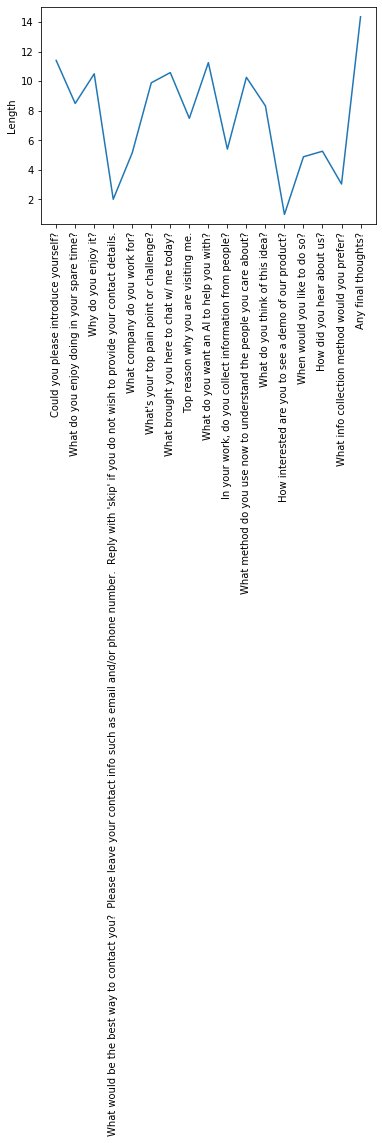

In [18]:
qResInfo,qResLen =  main(True,'test-set/welcome.csv')

In [19]:
qResInfo

{'Any final thoughts?': 163.60568782535924,
 'Could you please introduce yourself?': 128.9364901181055,
 'How did you hear about us?': 61.499301772392485,
 'How interested are you to see a demo of our product?': 8.56183820589491,
 'In your work, do you collect information from people?': 65.10206455428894,
 'Top reason why you are visiting me.': 83.55847477017859,
 'What brought you here to chat w/ me today?': 119.29407773015434,
 'What company do you work for?': 60.22139614339893,
 'What do you enjoy doing in your spare time?': 96.75743468766241,
 'What do you think of this idea?': 96.07578521369173,
 'What do you want an AI to help you with?': 126.54579331453976,
 'What info collection method would you prefer?': 37.852304410743535,
 'What method do you use now to understand the people you care about?': 118.93157587755056,
 "What would be the best way to contact you?  Please leave your contact info such as email and/or phone number.  Reply with 'skip' if you do not wish to provide your

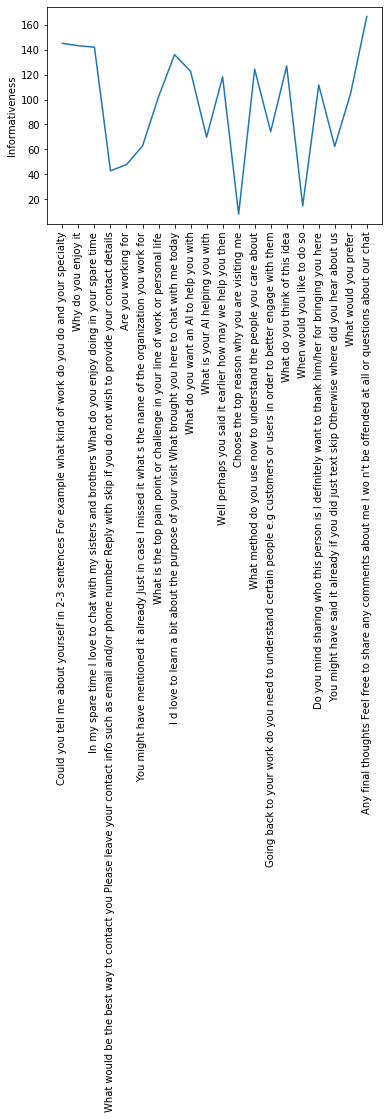

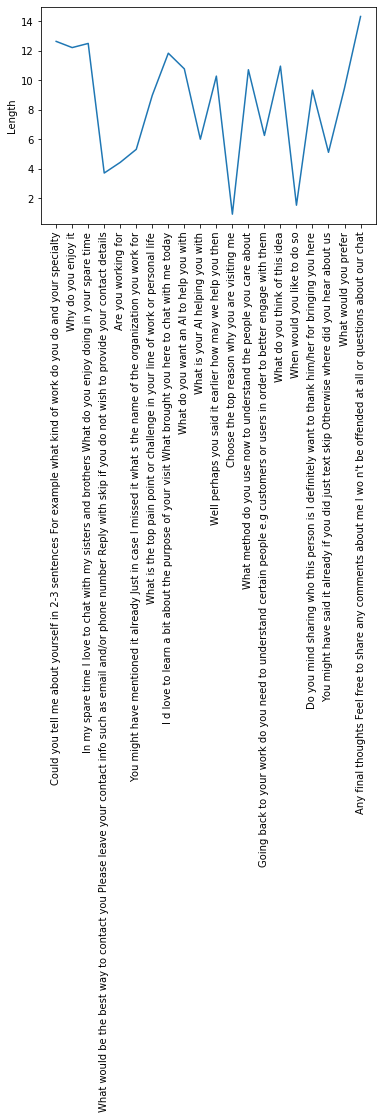

In [20]:
qResInfo,qResLen =  main(False,None,'test-set/welcome-transcripts/*.txt','test-set/welcome.edn')

In [21]:
qResInfo

{"Any final thoughts Feel free to share any comments about me I wo n't be offended at all or questions about our chat": 166.75833376841388,
 'Are you working for': 47.790017966174894,
 'Choose the top reason why you are visiting me': 7.944180669633865,
 'Could you tell me about yourself in 2-3 sentences For example what kind of work do you do and your specialty': 145.1572935785233,
 'Do you mind sharing who this person is I definitely want to thank him/her for bringing you here': 111.72921110848307,
 'Going back to your work do you need to understand certain people e.g customers or users in order to better engage with them': 74.2454246158977,
 'I d love to learn a bit about the purpose of your visit What brought you here to chat with me today': 136.14104518294423,
 'In my spare time I love to chat with my sisters and brothers What do you enjoy doing in your spare time': 142.05538117381627,
 'Well perhaps you said it earlier how may we help you then': 118.27897200857764,
 'What do you t

In [22]:
qResLen

{"Any final thoughts Feel free to share any comments about me I wo n't be offended at all or questions about our chat": 14.333333333333334,
 'Are you working for': 4.428571428571429,
 'Choose the top reason why you are visiting me': 0.9112903225806451,
 'Could you tell me about yourself in 2-3 sentences For example what kind of work do you do and your specialty': 12.643153526970954,
 'Do you mind sharing who this person is I definitely want to thank him/her for bringing you here': 9.333333333333334,
 'Going back to your work do you need to understand certain people e.g customers or users in order to better engage with them': 6.257142857142857,
 'I d love to learn a bit about the purpose of your visit What brought you here to chat with me today': 11.841059602649006,
 'In my spare time I love to chat with my sisters and brothers What do you enjoy doing in your spare time': 12.503778337531486,
 'Well perhaps you said it earlier how may we help you then': 10.285714285714286,
 'What do you 